# Lab: SVMs on Extended MNIST

In the [MNIST demo](demo_mnist_svm.ipynb), we saw how SVMs can be used for the classic MNIST problem of digit recognition. In this lab, we are going to extend the MNIST dataset by adding a number of non-digit letters and see if the classifier can distinguish the digits from the non-digits. All non-digits will be lumped as a single 11-th class. This is a highly simplified version of 'detection' problem (as opposed to 'classification' problem). Detection is vital in OCR and related problems since the non useful characters must be rejected. 

In addition to the concepts in the demo, you will learn:
* Combine multiple datasets
* Select the SVM parameters (`C` and `gamma`) via cross-validation.
* Use the `GridSearchCV` method to search for parameters with cross-validation.

Note:  An [earlier version](lab_emnist_2017_partial.ipynb) of this lab made you manually create the combined letter and digit data.  In this lab, we will download the data from NIST website.  But, the old lab is still useful to look at if you want to see how to use `skimage` package for a number of image pre-processing tasks.

As usual, we download the standard packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

## STEP 1: Downloading the EMNIST Dataset

After creating the highly popular MNIST dataset, NIST created an extended version of the dataset to include letters and digits.
  The extended datase (called EMNIST) also has many more examples per class.  

To download the data, first go to the [EMNIST webpage](https://www.nist.gov/itl/iad/image-group/emnist-dataset).  Near the bottom, you will see a link for `MATLAB format dataset`.  If you click on this link, you will download a `zip` file with several datasets in it.  The total file is 726M, so it may take some time and diskspace to download.  Extract two files:
* `emnist-digits.mat`:  This is a file of digits `0` to `9`, but with more examples per class.
* `emnist-letters.mat`:  This is a file of letters `a/A` to `z/Z`.  The lower and upper case letters are grouped into the same class.

Once you get these two files, you can save yourself the diskspace and remove all the other files.

In [ ]:
# TODO:  Download emnist-letters.mat and emnist-digits.mat to the working directory

## STEP 2: Extract Data

Since MATLAB files are still widely-used, Python has excellent routines for loading MATLAB files.  The function below uses the `scipy.io` package to extract the relevant fields from the MATLAB file.  Specifically, the function extracts the training and test data from MATLAB file. 

In [4]:
import scipy.io
def load_emnist(file_path='emnist-digits.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

Use the function above to get all the digit images from the `emnist-digits.mat` file.  

In [5]:
Xtr_dig, Xts_dig, ytr_dig, yts_dig = load_emnist("./matlab/emnist-digits.mat")

240000 training samples, 40000 test samples loaded


Next, use the function above to get all the letter characters from the `emnist-letters.mat` file.  

In [6]:
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist("./matlab/emnist-letters.mat")

124800 training samples, 20800 test samples loaded


We will use the function from the demo to plot the digits.

In [7]:
def plt_digit(x,y=None):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq.T,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])    
    if y != None:
        plt.title('%d' % y)        

#### Coding Exercise:

Plot 8 random samples from the digit training data.  You can use the `plt_digit` function above with `subplot` to create a nice display.  You may want to size your plot with the `plt.figure(figsize=(10,20))` command.

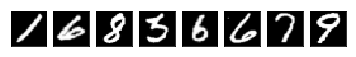

In [8]:
# Select random digits
nplt = 8
Iperm = np.random.permutation(nplt)

# Plot the images using the subplot command
for i in range(nplt):
    ...

Next, plot 8 samples from the letters training data.  You should see that the labels go from 0 to 25 corresponding to `a` to `z`.  Upper and lower case letters belong to the same class.

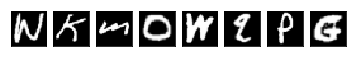

In [9]:
# TODO:  Plot 8 random samples from the training data of the letters
# Select random digits
nplt = 8
Iperm = np.random.permutation(nplt)

# Plot the images using the subplot command
for i in range(nplt):
    ...

## STEP 3: Creating a Non-Digit Class

**SVM classifiers are VERY SLOW to train.**  

The training is particularly slow when there are a large number of classes, since the one classifier must be trained for each pair of labels.  To make the problem easier, we are going to lump all of the letters in one class and add that class to the digits.  


Before we begin, we first need to remove all the letters corresponding to `i/I`, `l/L` and `o/O`.  The reason is that these letters would get confused with the digits `0` and `1`.  

Create arrays `Xtr_let_rem` and `ytr_let_rem` from the data `Xtr_let` and `ytr_let`, where the samples `i` with `ytr_let[i] == 9, 12` or `15` are removed.   Create `Xts_let_rem` and `yts_let_rem` similarly.

If you are clever, you can do this without a for-loop via python broadcasting and `np.all(..., axis=1)` command.  But, you will receive full marks if you use a `for-loop`.

In [11]:
remove_list = np.array([9,12,15])
remove_idx_tr = [x in remove_list for x in ytr_let]
remove_idx_ts = [x in remove_list for x in yts_let]
Xtr_let_rem, ytr_let_rem = Xtr_let[remove_idx_tr,:], ytr_let[remove_idx_tr]
Xts_let_rem, yts_let_rem = Xts_let[remove_idx_ts,:], yts_let[remove_idx_ts]

#### Coding Exercise:

Since training and testing an SVM is VERY SLOW, we will use only a small subset of the training and test data.  Of course, you will not get great results with this small dataset.  But, we can at least illustrate the basic concepts.  

Create arrays `Xtr1_dig` and `ytr1_dig` by selecting 5000 random training digit samples from `Xtr_dig` and `ytr_dig`.  Create arrays `Xtr1_let` and `ytr1_let` by selecting 1000 random training letter samples from `Xtr_let_rem` and `ytr_let_rem`.  Similarly, create test arrays `Xts1_dig,Xts1_let,yts1_dig,yts1_let` with 5000 digits and 1000 letters.

In [12]:
# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000

# TODO Create sub-sampled training and test data
# dig=digits, let=letters
Xtr1_dig, ytr1_dig = ...
Xts1_dig, yts1_dig = ...
Xtr1_let, ytr1_let = ...
Xts1_let, yts1_let = ...

#### Coding Exercise:


Next, we create data by combining the digit and letter arrays.
* Create an array `Xtr` by stacking `Xtr1_dig`, `Xtr1_let`.  This should result in 6000 total samples.
* Create a new label vector `ytr` where `ytr[i] = ytr1_dig[i]` for any digit sample and `ytr[i]=10` for any letter sample.  Thus, all the letters are lumped into a single class with label 11.

Create test arrays `Xts` and `yts` similarly. 

You may wish to use the `np.hstack` and `np.vstack` methods.

In [13]:
# TODO:  Create combined letter and digit training and test data
Xtr, ytr = ...
Xts, yts = ...

The training data above takes values from 0 to 255.  Rescale the data from -1 to 1.  This will get slightly better performance on the SVM.  Save the scaled data into arrays `Xtr1` and `Xts1`.

In [14]:
# TODO:  Rescale the data from -1 to 1
Xtr1 = ...
Xts1 = ...

## STEP 4: Run the SVM classifier

#### Coding Exercise:

First create the SVM classifer. Use an `rbf` classifier with `C=2.8` and `gamma=.0073`. We will look at how to select these parameters laters.

In [15]:
from sklearn import svm

# TODO:  Create a classifier: a support vector classifier
svc = ...

Fit the classifier using the scaled training data.  SVMs are insanely slow to train.  But, in this lab, we have kept the training size very small. So, the fitting should take about a minute or two.

In [16]:
svc.fit(Xtr1,ytr)

[LibSVM]

SVC(C=2.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=10)

Measure the accuracy on the test data.  This too will take another huge amount of time.  Print the accuracy.  If you did everything right, you should get an accuracy of around 85%.

In [17]:
# TODO:  Measure error on the test data
ypred_ts = ...

In [18]:
acc = np.mean(ypred_ts == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.857667


The error rate is quite a bit higher than what we got in the digits only case.  Actually, had we done a classifier using all 36 labels instead of collapsing the letters to a single class, the SVM classifier would have done much better.  The reason is that the "letters" class is now extremely complex.  


#### Coding Exercise:

Print a confusion matrix.  You should see that the error rate on the "letters" class is much higher.

In [19]:
# TODO:  Print a confusion matrix
from sklearn.metrics import confusion_matrix
...

array([[451,   0,  11,   3,   1,   5,   2,   0,   5,   1,   8],
       [  1, 442,   6,   2,   3,   3,   4,   1,   7,   2,  43],
       [  0,   0, 438,  26,   1,   7,   7,   1,  11,   0,   0],
       [  3,   0,   5, 393,   0,  18,   0,   2,   7,   6,   0],
       [  4,   0,   3,   1, 426,   5,   1,   0,   5,  27,   0],
       [  8,   2,   3,  14,   3, 404,  13,   0,  10,   3,   2],
       [  1,   1,   3,   0,   5,   3, 433,   0,   2,   0,   0],
       [  1,   2,   2,   1,   2,   0,   0, 445,   1,  26,   0],
       [  1,   2,   4,  12,   0,   6,   1,   1, 379,   6,   1],
       [  0,   0,   1,   2,  12,   2,   0,  12,   4, 389,   0],
       [ 93,  29,  49,  18,  69,  48,  33,  16,  63,  13, 946]])

Print:
* What fraction of digits are mislabeled as letters?  
* What fraction of letters are mislabeled as digits?

In [20]:
# TODO:  Print above two error rates
all_true_letters = ...
all_true_digits = ...
num_digits_classified_letters = ...
num_letters_classified_digits = ...
percent_dig_pred_let = num_digits_classified_letters / all_true_digits
percent_let_pred_dig = num_letters_classified_digits / all_true_letters
print("{0}% digits are classified as letters".format(percent_dig_pred_let*100))
print("{0}% letts are classified as digits".format(percent_let_pred_dig*100))

9.322950465065974% digits are classified as letters
3.9215686274509802% letts are classified as digits


## STEP 5: Selecting C via Cross-Validation

In the above example, and in the demo, we used a given  `C` value.  The selection of the parameters depend on the problem and decent performance of the SVM requires that you select these parameters carefully.  The best way to select the parameters is via cross validation.  Specifically, one tries different values of  `C` and selects the pair of values the lowest test error rate.

Since this type of parameter search is so commonly used, `sklearn` has an excellent method `GridSearchCV` that can perform all the operations for you.  In this lab, `GridSearchCV` is not that useful.  But, once you get to more complex parameter searches, the `GridSearchCV` method can save you writing a lot of code.  Importantly, `GridSearchCV` supports parallelization so that fits with different parameters can be fit at the same time.  In this optional section, we will show how to use this method.  

#### Coding Exercise:

The `GridSearchCV` method does the train-test split in addition to the parameter search.  In this case, you have already a fixed train-test split.  So, you first need to combine the train and test data back into a single dataset.

**For demonstration purpose, we will only use a subset of X and y for cross validation.**

In [21]:
# TODO:  Create combined trained and test data X and y.
need_idx = np.random.permutation(len(ytr))[:2000]
X_cv = Xtr1[need_idx, :]
y_cv = ytr[need_idx]

Next, read about the `GridSearchCV` method to set up a classifier that includes searching over the parameter grid.  

In [22]:
# TODO:  Create a GridSearchCV classifier
from sklearn.model_selection import GridSearchCV
svc = svm.SVC(verbose=10)
parameters = {'kernel':["linear"], 'C':[0.1,1,10]}
clf = GridSearchCV(svc, parameters)

Fit the classifier using the `fit` method.  The fit method will now search over all the parameters. This will take about 30 minutes.

In [23]:
clf.fit(X_cv, y_cv)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=10),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Print the `best_score_` and `best_params_` attributes of the classifier to find the best score and parameters

In [24]:
# TODO:  Print the best parameter and score of the classifier
print(clf.best_score_)
print(clf.best_params_)

0.783
{'C': 0.1, 'kernel': 'linear'}


Finally, you can print the test and train score from the `cv_results_['mean_test_score']`.

In [29]:
# TODO:  Print the mean test score for each parameter value.
print(clf.cv_results_['mean_test_score'])

[0.783  0.7665 0.7645]


## STEP 6: Model Analytics

Let's first fit a svm on Xtr1 that uses the C selected in the cross validation.

In [30]:
best_c = clf.best_params_["C"]
cv_svm = svm.SVC(probability=True, C=best_c,verbose=10, kernel="linear")

In [31]:
cv_svm.fit(Xtr1, ytr)

[LibSVM]

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=10)

Let's obtain the prediction on the test set.

In [32]:
y_pred = cv_svm.predict(Xts1)
y_pred_prob = cv_svm.predict_proba(Xts1)

#### Accuracy

In [33]:
acc = np.sum(y_pred==yts)/len(yts)
print("Accuracy = {0}".format(acc))

Accuracy = 0.8495


#### Macro-averaging v.s. Micro-averaging

In [34]:
from sklearn.metrics import precision_score, recall_score,f1_score
pr_ma = precision_score(yts, y_pred, average='macro')
pr_mi = precision_score(yts, y_pred, average='micro')
re_ma = recall_score(yts, y_pred, average='macro')
re_mi = recall_score(yts, y_pred, average='micro')
f1_ma = f1_score(yts, y_pred, average='macro')
f1_mi = f1_score(yts, y_pred, average='micro')
print("precision (macro) = {0}".format(pr_ma))
print("precision (micro) = {0}".format(pr_mi))
print("recall (macro) = {0}".format(re_ma))
print("recall (micro) = {0}".format(re_mi))
print("F1 (macro) = {0}".format(f1_ma))
print("F1 (micro) = {0}".format(f1_mi))

precision (macro) = 0.8753299174324596
precision (micro) = 0.8495
recall (macro) = 0.858175438624233
recall (micro) = 0.8495
F1 (macro) = 0.8649037877493381
F1 (micro) = 0.8495


#### Macro-AUC

In [35]:
y_pred_prob[0]

array([0.46026208, 0.00073027, 0.01249143, 0.00639154, 0.0040955 ,
       0.03054601, 0.01526808, 0.00164838, 0.01546911, 0.01541528,
       0.43768233])

In [36]:
from sklearn.metrics import roc_auc_score
auc_ma_ovr = roc_auc_score(yts, y_pred_prob, multi_class="ovr", average="macro")
auc_ma_ovo = roc_auc_score(yts, y_pred_prob, multi_class="ovo", average="macro")

In [37]:
print("Macro AUC ovr = {0}".format(auc_ma_ovr))
print("Macro AUC ovo = {0}".format(auc_ma_ovo))

Macro AUC ovr = 0.9842412324749467
Macro AUC ovo = 0.9853416761778488
